# PostNewtonian approximation vs LAL simulated signal

We can compare the simulated wave behaviour against what can be predicted by the equations obtained by combining the linearization of Einstein's equations\
We begin defining the useful equations

In [ ]:
import pandas as pd
import numpy as np
# Use a raw string or double backslashes for the path
file_path = r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroGW\GW-signals\GW150914.txt"  # Use the correct path to your file

# Read the file
data = pd.read_csv(file_path, sep="\t", header=0, names=["time", "h_+", "h_x"])

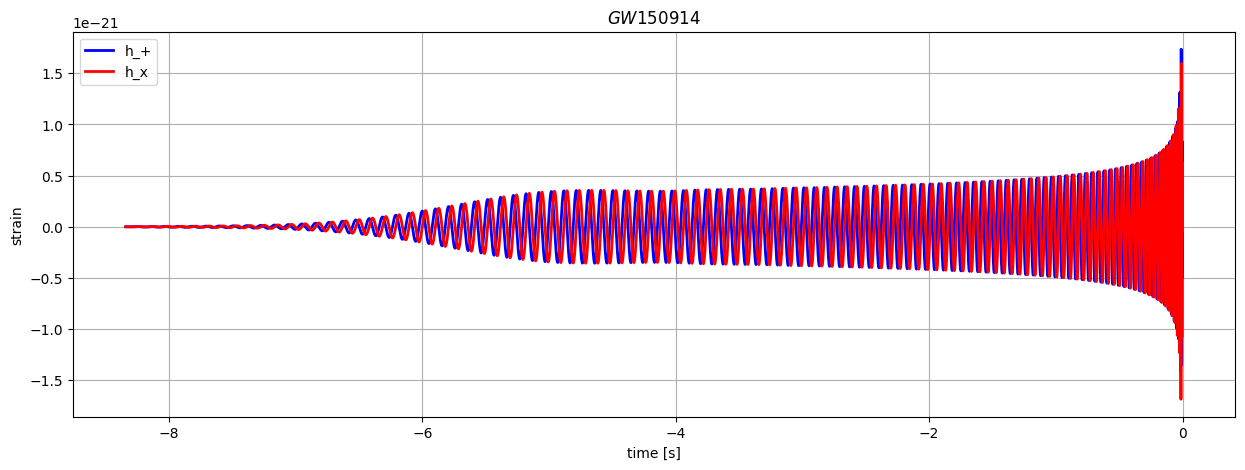

In [557]:
import matplotlib.pyplot as plt


fig, _ = plt.subplots(figsize=(15,5))
plt.plot(data['time'].values[data['time'].values<0],data['h_+'].values[data['time'].values<0], label='h_+', color='blue', linewidth=2)
plt.plot(data['time'].values[data['time'].values<0],data['h_x'].values[data['time'].values<0], label='h_x', color='red', linewidth=2)
plt.xlabel('time [s]')
plt.ylabel('strain')
plt.grid()
plt.title(r'$GW150914$')
#plt.text(-.5,5.1*1e-21, r"$m_{1}=37 M_{\odot}$, $m_{2}=40M_{\odot}$ , D = 100MPc", fontsize=14)
plt.legend()

The equations we need are:
1.  $\mathcal{M_c} = \mu^{3/5} M^{2/5} $
2.  $ \nu_{GW}(t) = \frac{5^{3/8}}{8\pi} \left(\frac{c^3}{G\mathcal{M}}\right)^{5/8} (t-t_c)^{-3/8} $
3.  $ \Phi(t) = - \frac{1}{16} \left(\frac{c^3}{G}\right)^{5/3}  (\pi \mathcal{M}\nu_{GW})^{-5/3} + \Phi_c$
4.  $ h(t) = \frac{4\pi^{2/3}G^{5/3}}{c^4} \frac{\mathcal{M^{5/3}}}{D}\nu_{GW}(t)^{2/3} \cos(\Phi(t))  $

In [491]:
from astropy import constants as cnst
from astropy import units as u

In [492]:
# Constants
G = cnst.G.cgs  # Gravitational constant (cm^3/g/s^2)
c = cnst.c.cgs  # Speed of light (cm/s)
msun = cnst.M_sun.cgs  # Solar mass (g)

In [493]:
# Binary Black Hole Parameters
m1 = 29.1 * msun  # Mass of first BH
m2 = 36.2 * msun  # Mass of second BH
M = m1 + m2  # Total mass
mu = (m1 * m2) / M  # Reduced mass

# Chirp Mass
Mc = (mu ** (3/5))*(M ** (2/5))  # Chirp mass in g

# Luminosity distance (100 Mpc)
D = (410 * u.Mpc).cgs  # Convert to cm

In [513]:
tc = data['time'][data['time']>-2].values[0]  # Coalescence time (negative value)
time = np.linspace(tc - 1e-3, -0.001, 1000)  # Create time array slightly before tc

In [ ]:
nu = (1 / np.pi) * ((256 / 5) * (G**(5/3) * Mc**(5/3)) / c**5 * np.abs(time))**(-3/8)
phi = -1/16 * (c**3/G)**(5/3) * (np.pi * Mc * nu)**(-5/3)   # phase development
h0  = 4*np.pi**(2/3)/(D*c**4) * (G*Mc)**(5/3) * nu.value**(2/3) * np.cos(phi.value)

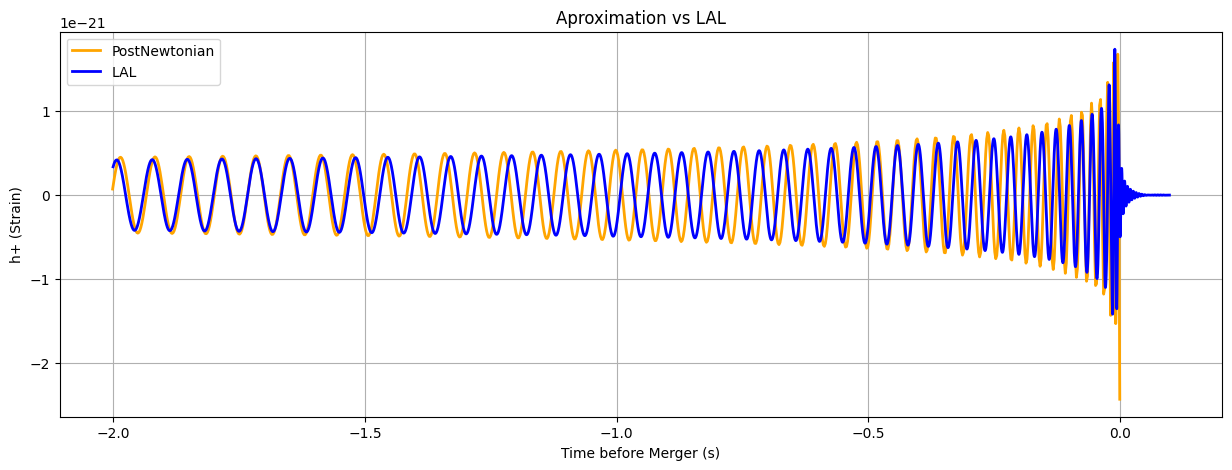

In [521]:
plt.figure(figsize=(15,5))
plt.plot(time, h0, linewidth=2, color='orange', label='PostNewtonian')
plt.plot(data['time'].values[data['time'].values>-2],data['h_+'].values[data['time'].values>-2], label='LAL', color='blue', linewidth=2)
plt.xlabel("Time before Merger (s)")
plt.ylabel("h+ (Strain)")
plt.title("Aproximation vs LAL")
plt.legend()
plt.grid()

Notes:
1. The further back one goes from the coalescence time the better the match. This is due to how $a(t)$ was computed. In fact $a(t) = a_0 \left( 1 - \frac{t}{t_c} \right) \to 0$ as $t \to t_c$ but since $\Omega = \sqrt{\frac{GM}{a^3}}$, then $\Omega \to \infty $ as $t \to t_c$.
2. No ringdown stage. The analytical solutions are valid only for $t < t_c$. Thi is also becouse of how the expression for $a(t)$ was derived. We computed it from $\frac{dE_{\text{BHB}}}{dt} + L{\text{GW}} = 0$ supposing that $E_{\text{BHB}} = -\frac{GM\mu}{2a}$ and $L_{\text{GW}} = \frac{32}{5} \frac{G^4}{c^5} \frac{M^3 \mu^2}{a^3}$ which are Newtonian approximations. In Newtonian dynamics black holes are not expected.

We can now look at the PSD

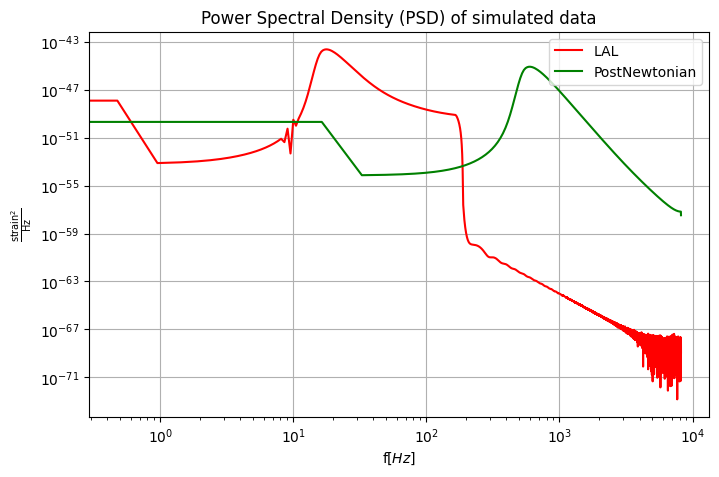

In [ ]:
from scipy.interpolate import interp1d
from scipy.signal import welch

# Parameters
fs = 1/np.mean(np.diff(data['time'].values[data['time'].values > -2]))  # Replace with your actual sampling frequency
NFFT = int(4 * fs)  # Increase segment size to smooth PSD
fmin = 10
fmax = 200

# Compute PSD using Welch's method (Better than mlab.psd)
freqs_LAL, Pxx_LAL = welch(data['h_+'].values[data['time'].values > -2], fs=fs, nperseg=NFFT)
freqs_any, Pxx_any = welch(h0, fs=fs, nperseg=NFFT)

# Plot the PSD
plt.figure(figsize=(8, 5))
plt.loglog(freqs_LAL, Pxx_LAL, 'r', label=r'LAL')
plt.loglog(freqs_any, Pxx_any, 'g', label=r'PostNewtonian')
plt.grid()
plt.ylabel(r'$\frac{\text{strain}^{2}}{\text{Hz}}$')
plt.xlabel(r'$\text{f} [Hz]$')
plt.legend(loc='upper right')
plt.title('Power Spectral Density (PSD) of simulated data')
plt.show()


In [595]:
import pywt

# Load time and h_+ data
t = data['time'].values[data['time'].values > -2]  
h_plus = data['h_+'].values[data['time'].values > -2]  

# Define scales (increase min scale to reduce high frequencies)
scales = np.arange(10, 256)  # Adjust for correct frequency range

wavelet = 'cmor'  # Complex Morlet wavelet

# Compute Continuous Wavelet Transform (CWT)
coefficients, _ = pywt.cwt(h_plus, scales, wavelet, sampling_period=t[1] - t[0])

# Convert scales to frequencies
frequencies = pywt.scale2frequency(wavelet, scales) / (t[1] - t[0])

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)
c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Lib\site-packages\pywt\_functions.py:141: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


In [596]:
# Define scales (increase min scale to reduce high frequencies)
scales2 = np.arange(10, 512)  # Adjust for correct frequency range

# Compute Continuous Wavelet Transform (CWT)
coefficients2, _ = pywt.cwt(h0, scales, wavelet, sampling_period=time[1] - time[0])

# Convert scales to frequencies
frequencies2 = pywt.scale2frequency(wavelet, scales2) / (t[1] - t[0])

Text(0.5, 1.0, 'Wavelet Spectrogram of PostNewtonian Gravitational Wave Signal')

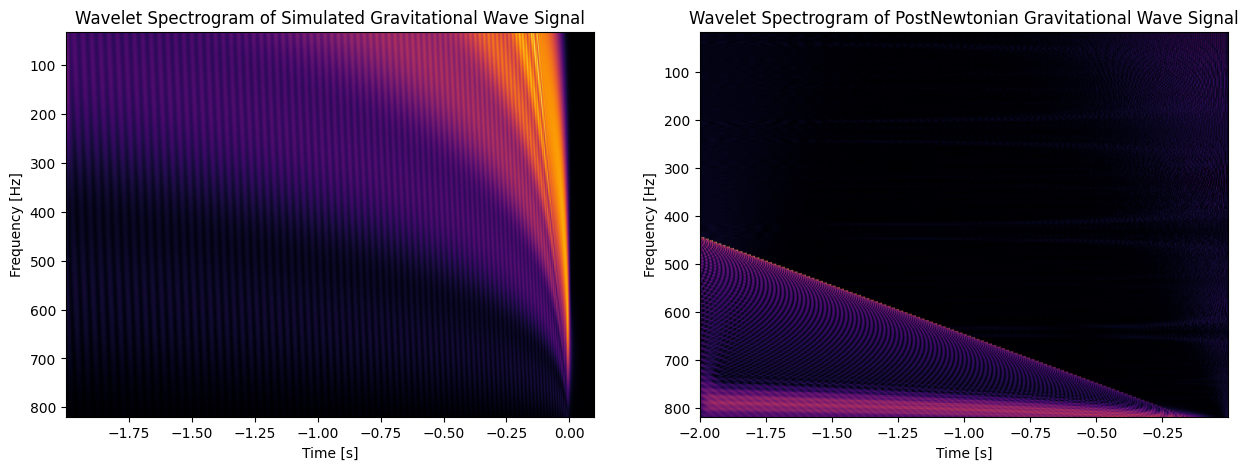

In [612]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

# Plot the spectrogram
axs[0].imshow(abs(coefficients), aspect='auto',
           extent=[t[0], t[-1], frequencies[0], frequencies[-1]],
           cmap='inferno', origin='lower')

axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Frequency [Hz]")
axs[0].set_title("Wavelet Spectrogram of Simulated Gravitational Wave Signal")
#axs[0].set_yscale("log")  # Log scale for better visualization of lower frequencies

axs[1].imshow(abs(coefficients2), aspect='auto',
           extent=[time[0], time[-1], frequencies2[0], frequencies2[-1]],
           cmap='inferno', origin='lower')

axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Frequency [Hz]")
axs[1].set_title("Wavelet Spectrogram of PostNewtonian Gravitational Wave Signal")
#axs[1].set_yscale("log")  # Log scale for better visualization of lower frequencies
#plt.colorbar(label='Magnitude')  # Color represents magnitude

In [658]:
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

# Compute analytic signal using Hilbert Transform
analytic_signal = hilbert(h_plus)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))  # Unwrap phase
instantaneous_frequency = np.gradient(instantaneous_phase) / (2 * np.pi * (t[1] - t[0]))

analytic_signal2 = hilbert(h0)
instantaneous_phase2 = np.unwrap(np.angle(analytic_signal2))  # Unwrap phase
instantaneous_frequency2 = np.gradient(instantaneous_phase2) / (2 * np.pi * (time[1] - time[0]))

# Compute time derivative of instantaneous frequency
smoothed_freq = gaussian_filter1d(instantaneous_frequency, sigma=5)  # Adjust sigma as needed
smoothed_freq2 = gaussian_filter1d(instantaneous_frequency2, sigma=5)  # Adjust sigma as needed
df_dt = np.gradient(smoothed_freq) / (t[1] - t[0])
df_dt2 = np.gradient(smoothed_freq2) / (time[1] - time[0])

C:\Users\ricca\AppData\Local\Temp\ipykernel_1916\583547077.py:55: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


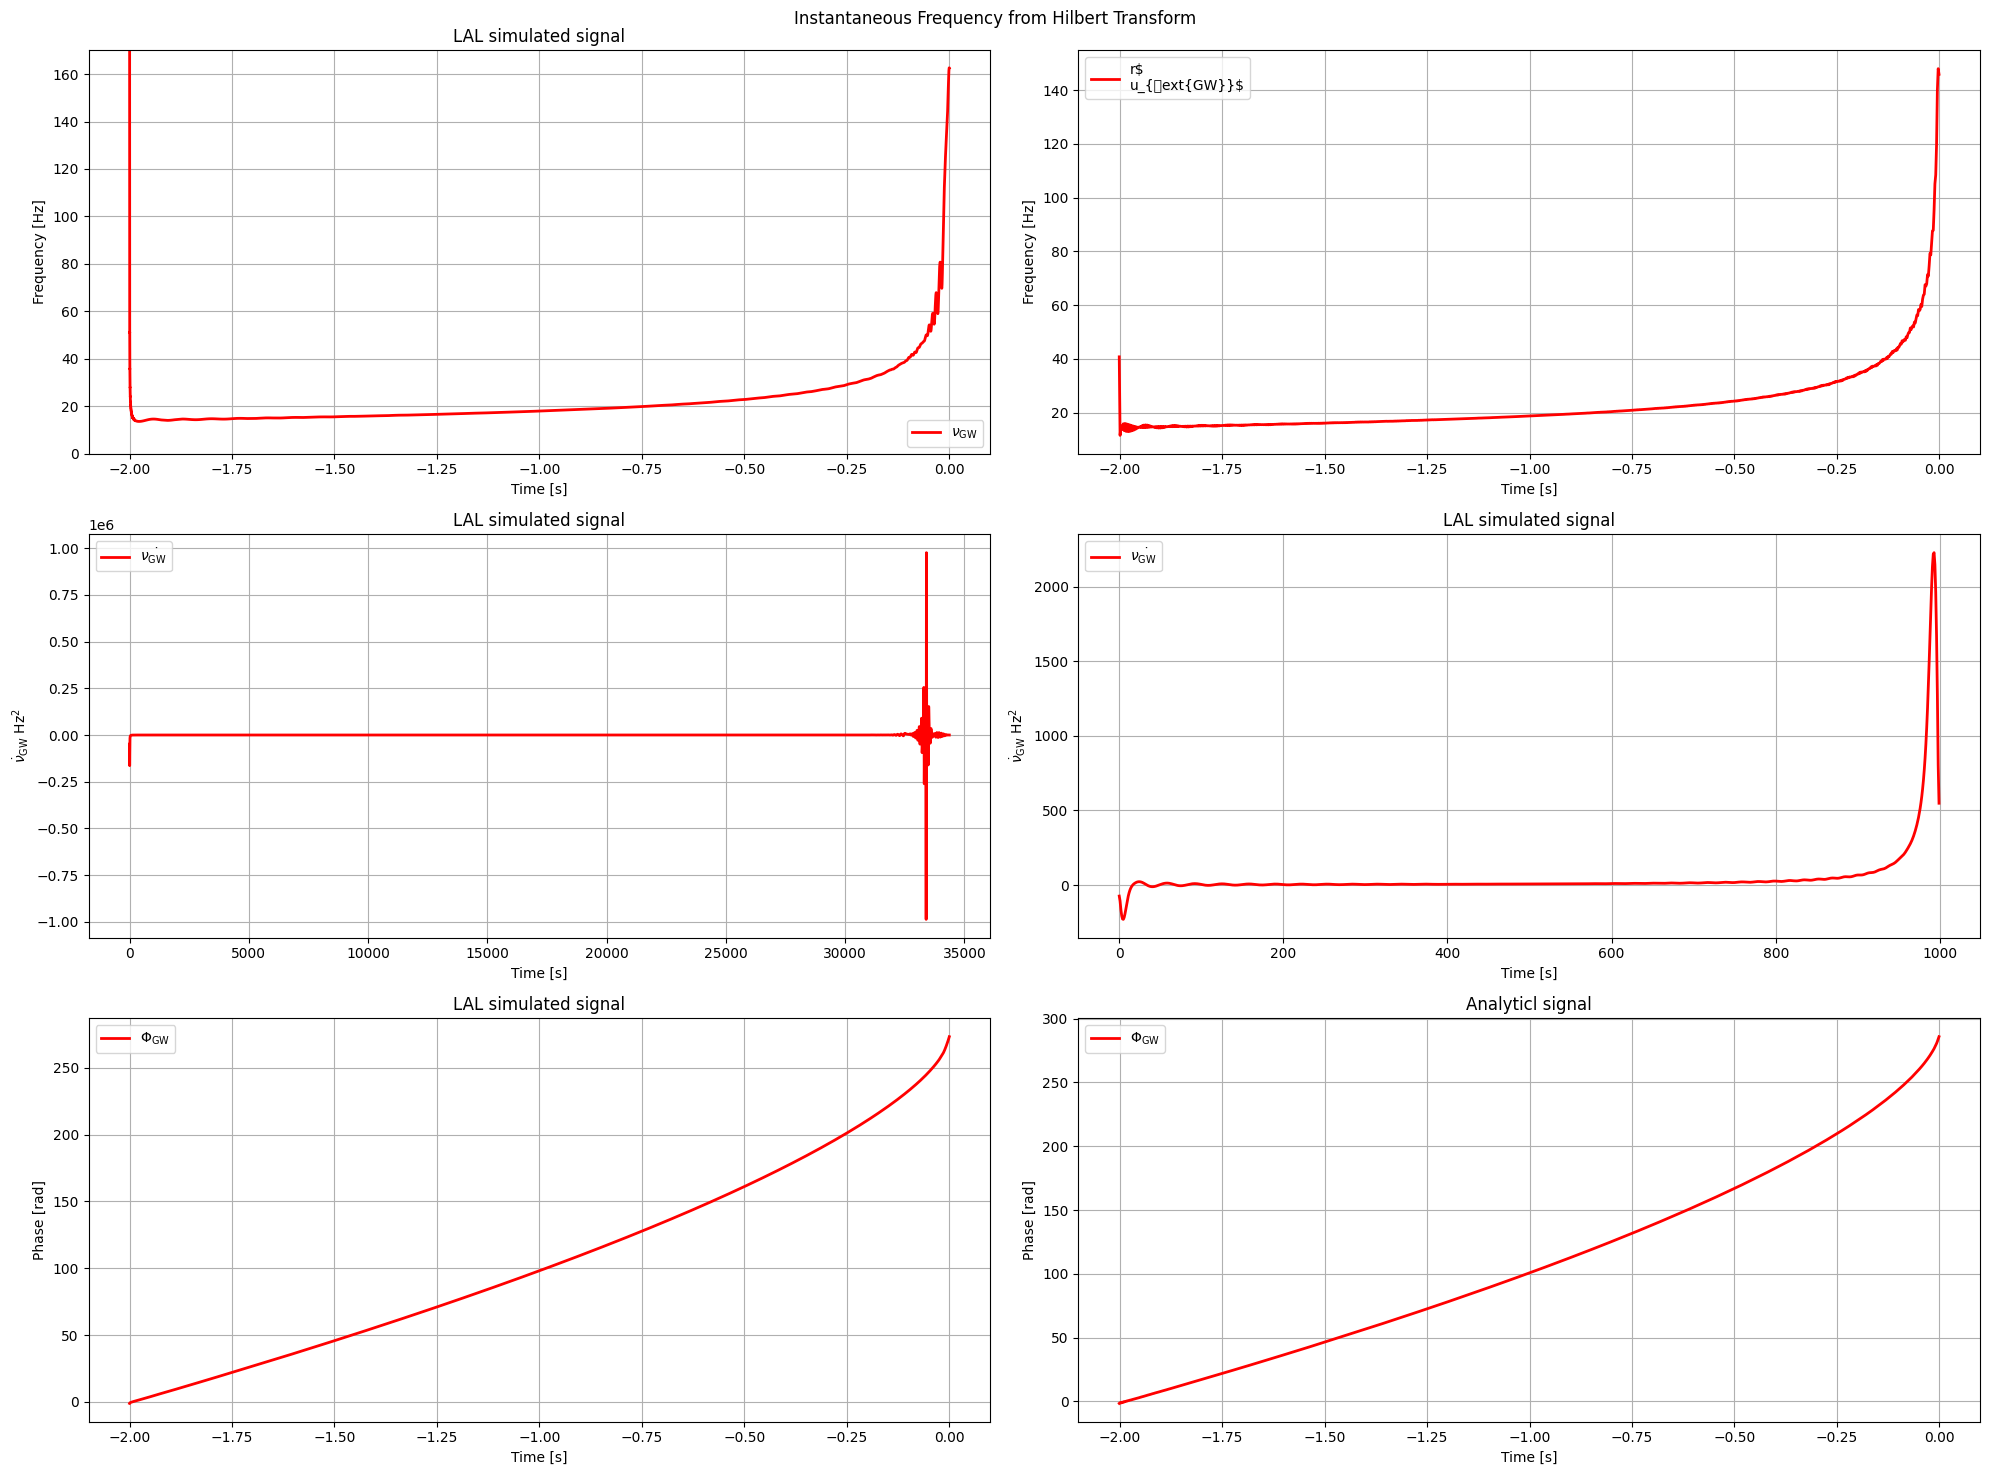

In [659]:
fig, axs = plt.subplots(3,2,figsize=(20,15))

axs[0][0].plot(t[t<0], instantaneous_frequency[t<0], label=r"$\nu_{\text{GW}}$", color='r', linewidth=2)
axs[0][0].set_xlabel("Time [s]")
axs[0][0].set_ylabel("Frequency [Hz]")
axs[0][0].set_title("LAL simulated signal")
#axs[0][0].set_yscale("log")
axs[0][0].grid()
axs[0][0].set_ylim([0,170])
axs[0][0].legend()

axs[2][0].plot(t[t<0], instantaneous_phase[t<0], label=r"$\Phi_{\text{GW}}$", color='r', linewidth=2)
axs[2][0].set_xlabel("Time [s]")
axs[2][0].set_ylabel("Phase [rad]")
axs[2][0].set_title("LAL simulated signal")
#axs[1][0].set_yscale("log")
axs[2][0].grid()
axs[2][0].legend()

axs[1][0].plot(df_dt, label=r"$\dot{\nu_{\text{GW}}}$", color='r', linewidth=2)
axs[1][0].set_xlabel("Time [s]")
axs[1][0].set_ylabel(r"$\dot{\nu}_{\text{GW}}$ $\text{Hz}^{2}$")
axs[1][0].set_title("LAL simulated signal")
#axs[0][0].set_yscale("log")
axs[1][0].grid()
axs[1][0].legend()

axs[1][1].plot(df_dt2, label=r"$\dot{\nu_{\text{GW}}}$", color='r', linewidth=2)
axs[1][1].set_xlabel("Time [s]")
axs[1][1].set_ylabel(r"$\dot{\nu}_{\text{GW}}$ $\text{Hz}^{2}$")
axs[1][1].set_title("LAL simulated signal")
#axs[0][0].set_yscale("log")
axs[1][1].grid()
axs[1][1].legend()


axs[0][1].plot(time[time<0], instantaneous_frequency2[time<0], label="r$\nu_{\text{GW}}$", color='r',linewidth=2)
axs[0][1].set_xlabel("Time [s]")
axs[0][1].set_ylabel("Frequency [Hz]")
#axs[0][1].set_title("Analytical signal")
axs[0][1].grid()
axs[0][1].legend()


axs[2][1].plot(time[time<0], instantaneous_phase2[time<0], label=r"$\Phi_{\text{GW}}$", color='r', linewidth=2)
axs[2][1].set_xlabel("Time [s]")
axs[2][1].set_ylabel("Phase [rad]")
axs[2][1].set_title("Analyticl signal")
#axs[1][1].set_yscale("log")
axs[2][1].grid()
axs[2][1].legend()


plt.suptitle('Instantaneous Frequency from Hilbert Transform')
plt.tight_layout()

In [690]:
term_inside_power = (5 / 96) * (df_dt2 / (np.pi**(8/3) * instantaneous_frequency2**(11/3)))
print("Any negative values in power term?", np.any(term_inside_power < 0))

valid_idx = (instantaneous_frequency2 > 1e-3) & (df_dt2 > 0)  # Avoid small freq and negative df/dt
chirp_mass = np.full_like(instantaneous_frequency2, 0)  # Initialize with NaNs
chirp_mass[valid_idx] = ((5 / 96) * (df_dt2[valid_idx] / (np.pi**(8/3) * instantaneous_frequency2[valid_idx]**(11/3))))**(3/5)


Any negative values in power term? True


Text(0.5, 1.0, 'Chirp Mass value distribution')

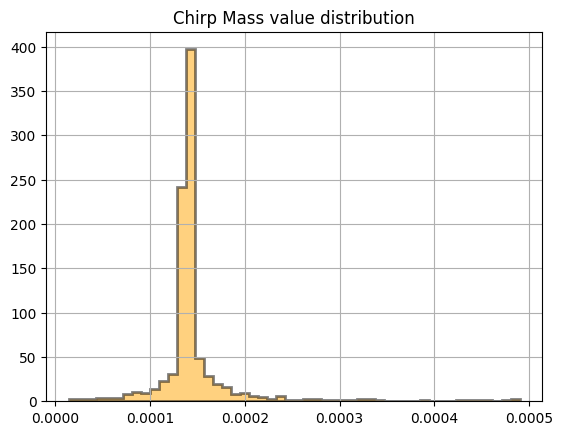

In [706]:
masses = chirp_mass[valid_idx]
counts, bins , _ = plt.hist(masses, bins=50, alpha=0.5, label='Chirp Mass', histtype='stepfilled', color='orange', edgecolor='black', linewidth=2)
plt.grid()
plt.title('Chirp Mass value distribution')

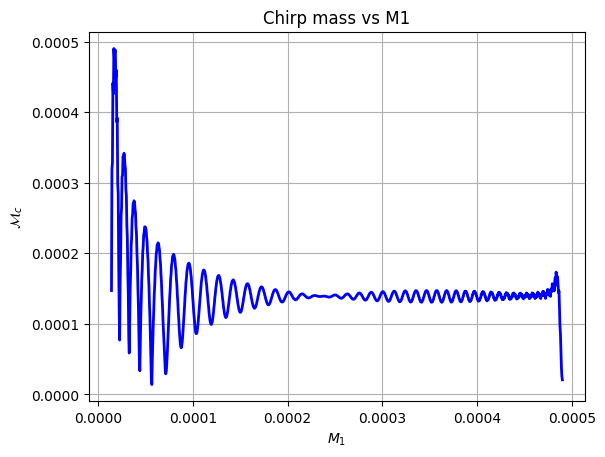

In [712]:
x = np.linspace(min(masses), max(masses), masses.shape[0])
plt.plot(x, masses,color='blue',linewidth=2)
plt.title('Chirp mass vs M1')
plt.xlabel(r'$M_1$')
plt.ylabel(r'$\mathcal{M}_c$')
plt.grid()